K-Means

In [1]:
%load_ext google.cloud.bigquery
%matplotlib inline
from google.cloud import bigquery
client = bigquery.Client()
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import cluster
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import random
from sklearn.cluster import KMeans
import matplotlib.cm as cm
%run silhouette_plotter.py

In [2]:
sql = '''
SELECT *  FROM `eth-tokens.alldata.clean_avg_with_balances_tokens`
'''

df = client.query(sql).to_dataframe()

In [3]:
#remove address (string) from analysis
data = df.iloc[:,1:]

In [4]:
#number of PCA features is full reconstruction, for now
num_features = data.shape[1]
num_clusters = 4

In [5]:
scale = StandardScaler()
pca =PCA(n_components=num_features)
cl = KMeans(num_clusters)
#build pipeline
pipe = Pipeline([('scale', scale ),
                 ('PCA', pca)])

results = pipe.fit_transform(data)

cl.fit(results)



KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [6]:
#get centroids
c = cl.cluster_centers_
#transform back to real numbers
medoids = scale.inverse_transform(pca.inverse_transform(c))
pd.DataFrame(medoids, columns = data.columns)

,outgoing_txns,incoming_txns,total_eth_sent,avg_eth_sent,total_usd_sent,avg_usd_sent,total_eth_recd,avg_eth_recd,total_usd_recd,avg_usd_recd,...,monthly_eth_recd,monthly_usd_recd,contracts_created,contract_txns_sent,incoming_avg_time_btwn_txns,incoming_std_time_btwn_txns,outgoing_avg_time_btwn_txns,outgoing_std_time_btwn_txns,num_tokens_used,eth_balance
0,37.824457,46.211334,3.487076e+02,11.568077,1.232941e+05,5135.925277,3.625734e+02,11.854905,1.281718e+05,4.876962e+03,...,25.293467,1.049090e+04,5.174231e-01,1.777162e+01,1.088909e+06,1.393957e+06,1.427818e+06,1.676364e+06,8.869421,9.985769
1,647655.000000,727.000000,6.159823e+06,9.510963,3.714534e+09,5735.358548,6.276248e+06,8633.078188,3.767629e+09,5.182433e+06,...,570567.985720,3.425117e+08,2.224110e-12,2.171596e-11,3.667699e+04,5.331568e+04,4.115239e+01,1.296313e+03,310.000000,28796.708750
2,6.405524,9.710450,3.928317e+02,35.168519,7.317338e+04,8594.586249,4.931960e+02,40.576927,4.792241e+04,5.079401e+03,...,22.232889,3.764760e+03,1.469199e-01,4.393329e+00,4.462435e+06,5.699266e+06,5.605039e+06,6.583696e+06,7.219368,32.111644
3,266092.250000,174631.000000,6.975334e+06,941.975916,1.388202e+09,305238.452481,6.933007e+06,802.901498,1.373537e+09,2.859746e+05,...,391579.777656,1.145559e+08,5.729861e-13,2.195755e-11,4.037431e+03,9.626279e+03,4.273013e+03,1.258338e+04,143.750000,12862.104906


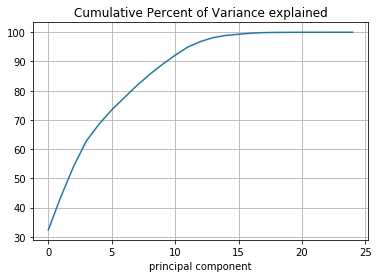

In [7]:
#percent of variance explained by each component

plt.plot(np.arange(pca.n_components_) ,np.cumsum(pca.explained_variance_ratio_)*100)
plt.grid(b=True)
plt.xlabel('principal component')
plt.title('Cumulative Percent of Variance explained')
plt.show()

In [8]:
#elbow method


Text(0.5,1,'Calinski Harabaz Scores')

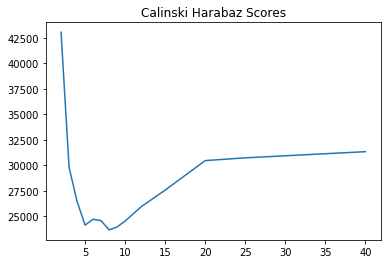

In [9]:
#scoring metric?
from sklearn.metrics import calinski_harabaz_score as ch_score
clusters = [2, 3,4,5,6,7,8,9,10,12,15,20,25, 40]
scores = []
inertias = []
for c in clusters:
    cl_n = KMeans(c).fit(results)
    score = ch_score(results, cl_n.labels_)
    scores.append(score)
    inertias.append(cl_n.inertia_)


plt.plot(clusters, scores)
plt.title('Calinski Harabaz Scores')

Text(0,0.5,'within cluster sum of squares')

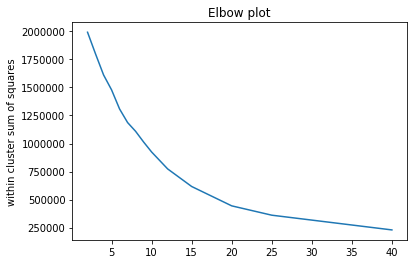

In [10]:
plt.plot(clusters,inertias)
plt.title('Elbow plot')
plt.ylabel('within cluster sum of squares')

In [11]:
#optmal number of clusters is around 15
cl = KMeans(15)
cl.fit(results)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=15, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [12]:
#outlier removal


def remove_outliers(results, cl, threshold):
    '''
    returns subset of results, and associated labels as a tuple
    takes results and a fit KMeans cluster object'''
    
    new_labels = []
    new_results = []
    
    
    #code for deciding what clusters to keep
    for i, center in enumerate(cl.cluster_centers_):
        within_cluster_results = results[cl.labels_==i]
        centroid = cl.cluster_centers_[i]
        #calc std vectors
        stdev = np.std(within_cluster_results, axis=0)
       
        keep = np.linalg.norm((centroid - within_cluster_results), axis=1) < threshold*np.linalg.norm(stdev)
        new_results.append(within_cluster_results[keep])
        #add labels?
        new_labels.extend([i for j in range(len(within_cluster_results[keep]))])
    return np.vstack(new_results), np.array(new_labels)


In [13]:
thresholds = np.linspace(.3,3, 20)

test = [remove_outliers(results, cl,t) for t in thresholds]

scores= []
for (res, labels) in test:
    
    score = ch_score(res, labels)
    scores.append(score)

Text(0.5,1,'Calinski Harabaz Scores as std threshold changes')

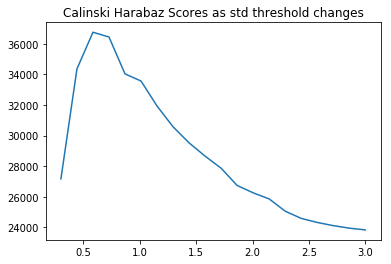

In [14]:
plt.plot(thresholds, scores)
plt.title('Calinski Harabaz Scores as std threshold changes')

In [15]:
#empirical best threshold .75 stdev
newresults, labels = remove_outliers(results, cl,.75)

In [16]:
X=newresults
range_n_clusters = [15]
if len(newresults) <20000:
    silhouette_plotter(X, range_n_clusters)

(-15, 10)

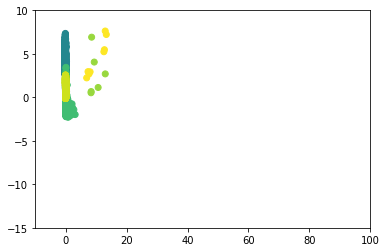

In [17]:

plt.scatter(newresults[:,0],newresults[:,1],c=labels)
plt.xlim(-10,100)
plt.ylim(-15,10)

(-15, 10)

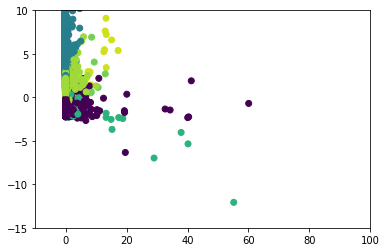

In [18]:
plt.scatter(results[:,0],results[:,1],c=cl.labels_)
plt.xlim(-10,100)
plt.ylim(-15,10)

In [19]:
#recluster after changes
cl = KMeans(15).fit(results)
newcl = KMeans(15).fit(newresults)

In [20]:
# %matplotlib widget
from mpl_toolkits.mplot3d import Axes3D

In [21]:
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(results[:,0],results[:,1],results[:,2],c=cl.labels_)

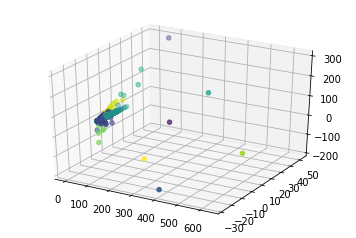

In [22]:

# plt.scatter(newresults[:,0],newresults[:,1],c=newcl.labels_)
# plt.xlim(-10,100)
# plt.ylim(-15,10)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(results[:,0],results[:,1],results[:,2],c=cl.labels_)

# ax.set_xlim3d(-10,10)
# ax.set_ylim3d(-15,10)
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(newresults[:,0],newresults[:,1],newresults[:,2],c=newcl.labels_)

FigureCanvasNbAgg()

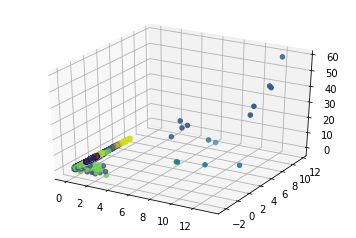

In [28]:
# %matplotlib widget
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(newresults[:,0],newresults[:,1],newresults[:,2],c=newcl.labels_)
# ax.set_xlim3d(-1,1)
# ax.set_ylim3d(-3,3)
# ax.view_init(elev=-0, azim=90)
# for ii in range(10,360,10):
#     ax.view_init(elev=10, azim=ii)
#     fig.savefig("movie/movie{}.png".format(ii))

In [24]:
c = newcl.cluster_centers_
#transform back to real numbers
centroids = scale.inverse_transform(pca.inverse_transform(c))
df_summary = pd.DataFrame(centroids, columns = data.columns)

In [25]:
cluster_sizes = pd.Series(newcl.labels_).value_counts()
df_summary['cluster_size'] = cluster_sizes

In [26]:
df_summary.sort_values('cluster_size', axis=0)

,outgoing_txns,incoming_txns,total_eth_sent,avg_eth_sent,total_usd_sent,avg_usd_sent,total_eth_recd,avg_eth_recd,total_usd_recd,avg_usd_recd,...,monthly_usd_recd,contracts_created,contract_txns_sent,incoming_avg_time_btwn_txns,incoming_std_time_btwn_txns,outgoing_avg_time_btwn_txns,outgoing_std_time_btwn_txns,num_tokens_used,eth_balance,cluster_size
6,15.000000,13.666667,14959.183518,933.640836,5.505330e+06,2.756467e+05,36852.119317,4537.916388,5.817620e+06,3.552742e+05,...,8.201636e+05,-1.629308e-12,-5.830003e-12,1.494359e+06,3.349044e+06,1.311041e+06,2.461519e+06,26.500000,37559.591503,6
4,9.222222,5.777778,44529.006674,5397.252391,1.856829e+07,2.341428e+06,47171.039839,7627.967964,2.053789e+07,3.719284e+06,...,1.898993e+06,7.474577e-13,-6.254552e-12,9.885200e+05,1.273156e+06,1.559757e+06,2.153852e+06,6.888889,1530.902942,9
13,3.984166,4.230207,25.752157,5.919564,9.456610e+03,2.313442e+03,32.136925,6.311360,9.900006e+03,2.281515e+03,...,6.957312e+02,1.705238e-02,6.455542e-02,7.919672e+06,1.045836e+07,8.373766e+06,1.036633e+07,4.331303,2.661145,821
3,41.742640,29.502374,326.549104,6.365160,1.696764e+05,3.142394e+03,315.880424,6.139585,1.606082e+05,3.045010e+03,...,1.414335e+04,4.292498e-01,4.962013e+00,1.254920e+06,1.481176e+06,1.032647e+06,1.339346e+06,107.074074,4.941074,1053
2,6.086988,4.639109,31.980025,5.206803,1.327834e+04,2.231445e+03,36.284264,7.387477,1.099622e+04,2.387090e+03,...,7.052512e+02,1.387491e-01,4.263120e-01,7.003589e+06,8.655138e+06,4.498516e+06,5.525679e+06,6.577283,3.193687,1391
9,4.018057,5.429016,24.238206,5.705725,1.091935e+04,2.641896e+03,27.941745,4.932324,1.147615e+04,2.178747e+03,...,8.778439e+02,2.117061e-02,3.798257e-01,5.076614e+06,6.881439e+06,7.235609e+06,8.695072e+06,4.528020,1.628356,1606
11,61.837138,42.623689,489.796471,6.689056,2.938492e+05,3.555120e+03,546.580942,6.670239,3.165197e+05,3.378860e+03,...,2.023617e+04,6.107341e-02,6.106724e+00,1.490537e+06,1.819910e+06,1.148603e+06,1.561605e+06,65.363973,7.346496,1621
12,5.521229,7.358939,28.748375,4.864249,1.435856e+04,2.513269e+03,33.057524,4.453961,1.550154e+04,2.127809e+03,...,1.132605e+03,2.346369e-02,4.279330e-01,3.224672e+06,4.369950e+06,4.344365e+06,5.264872e+06,5.295531,1.378717,3580
7,5.567140,16.570142,21.142900,3.767354,1.091286e+04,1.980002e+03,28.787120,2.770717,1.388044e+04,1.337899e+03,...,1.004963e+03,2.783843e-02,2.519105e-01,1.165309e+06,1.537768e+06,3.967794e+06,4.714362e+06,5.222162,1.728358,3665
0,9.434915,11.780076,53.432297,5.707547,2.405324e+04,2.506109e+03,63.067655,5.820231,2.511107e+04,2.228550e+03,...,1.512029e+03,7.628083e-02,8.576850e-01,2.143322e+06,3.081376e+06,2.398662e+06,3.154402e+06,8.139658,2.562732,5269


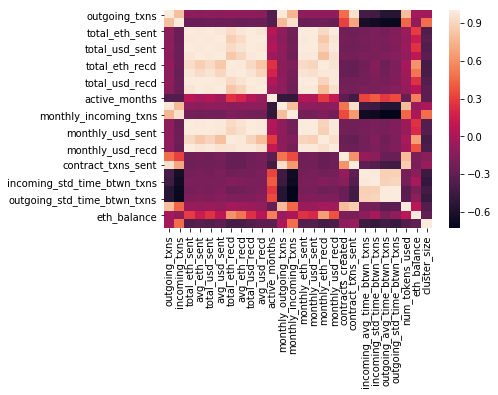

In [34]:
import seaborn as sns
sns.heatmap(df_summary.corr())

In [36]:
arr = df_summary.values

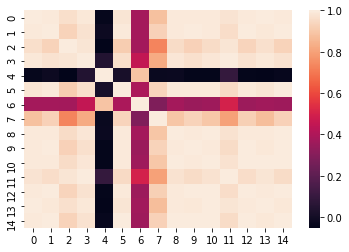

In [43]:
sns.heatmap(np.corrcoef(arr, rowvar=True))

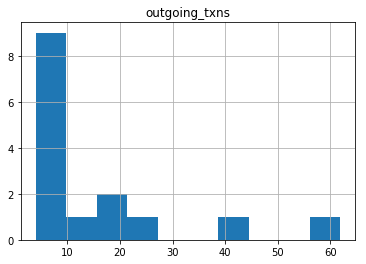

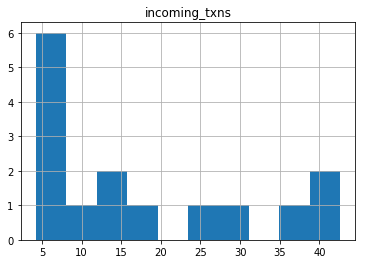

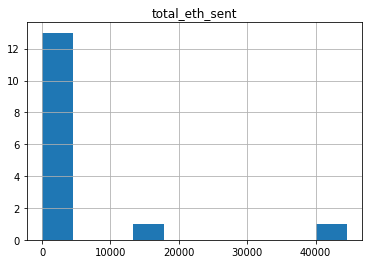

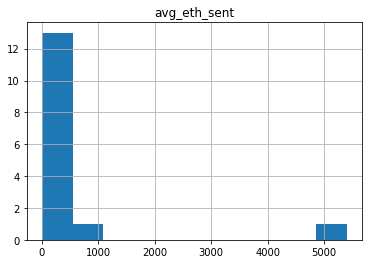

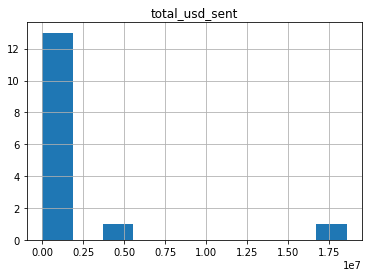

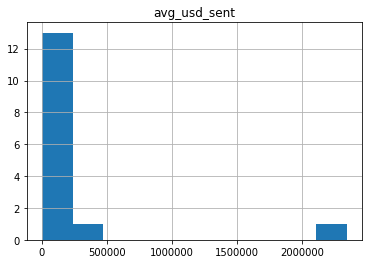

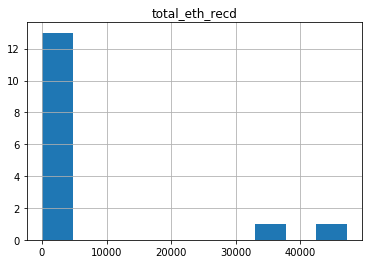

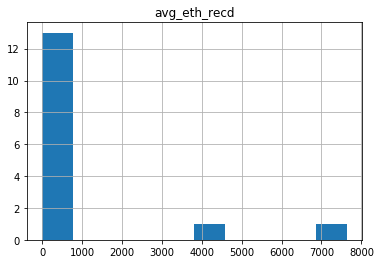

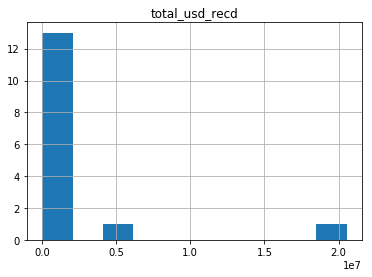

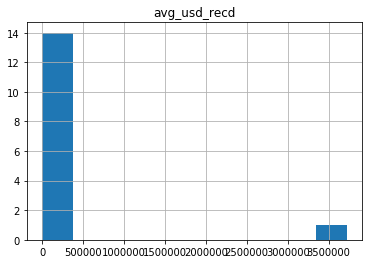

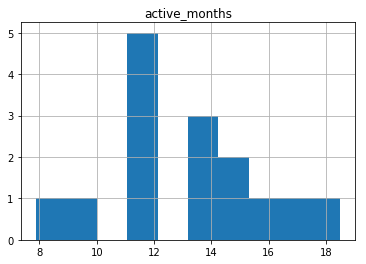

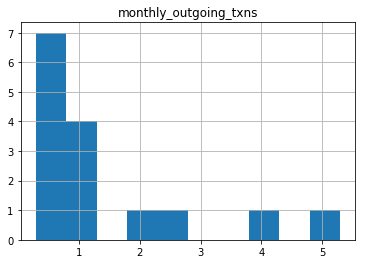

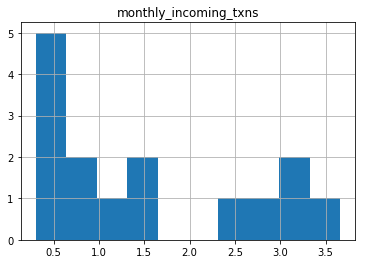

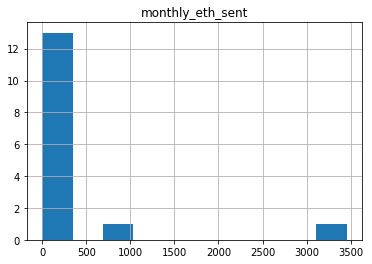

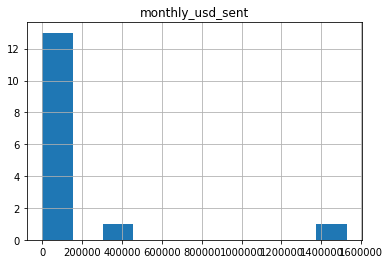

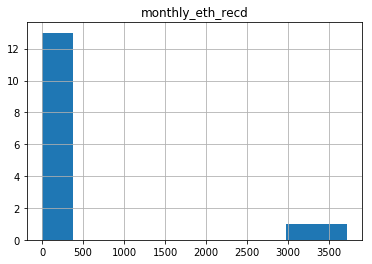

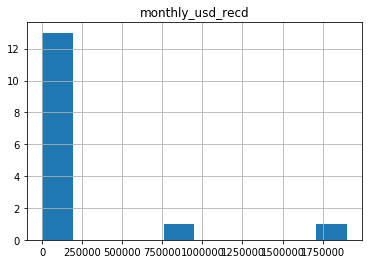

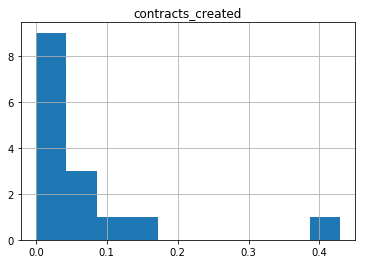

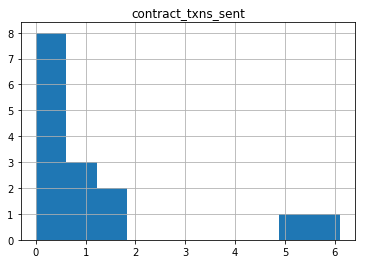

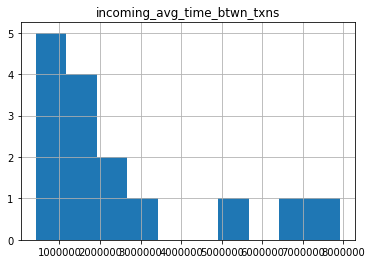

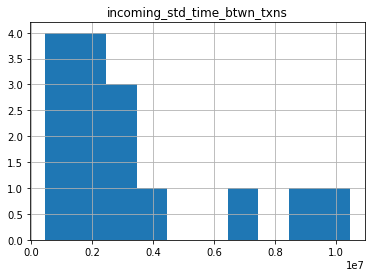

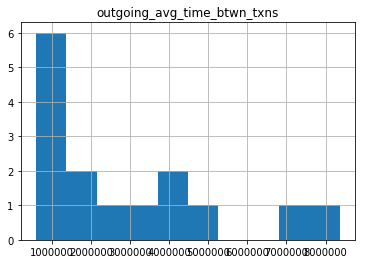

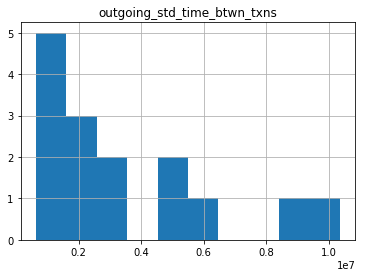

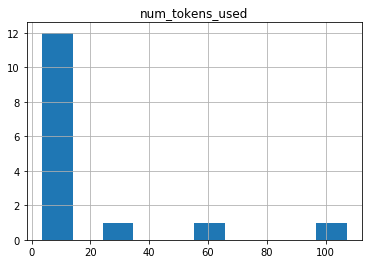

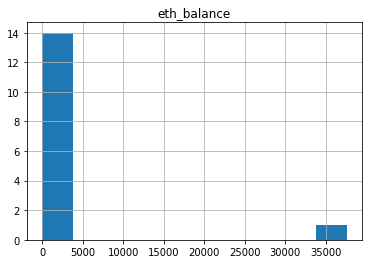

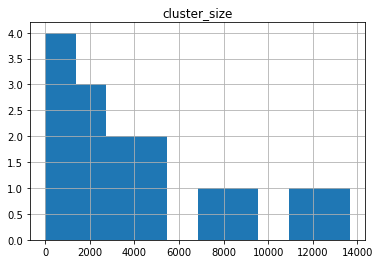

In [45]:
for col in df_summary.columns:
    df_summary[col].hist()
    plt.title(col)
    plt.show()

In [46]:
p = PCA(n_components=3)

In [52]:
vectors = p.fit_transform(arr)

In [69]:
z = np.zeros(15)
xs = vectors[:,0]
ys = vectors[:,1]
zs = vectors[:,2]

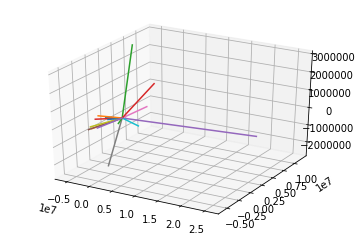

In [71]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for x,y,z in zip(xs,ys,zs):
    ax.plot([0,x], [0,y],[0,z])